## TODO: 
1. Get code to .py files
2. Change some names for better understanding
3. Investigate UN sampler
4. Implement Hierarchical clustering
5. Inference each layer and get Accuracy and Metrics
6. Test on 3D data
7. Test on  ellipses data and or other data

Some Notes:
- Dont Train the model every time, just save and load it
- Use metric to evaluate the model not just accuracy
- Save each training in a txt file
- Use the same seed for each training (for reproducibility)

In [207]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
# def variable
from torch.autograd import Variable

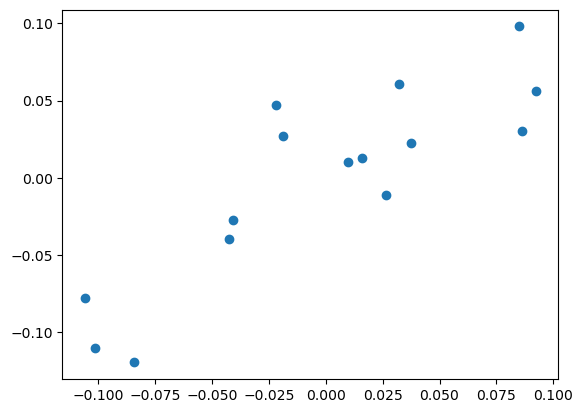

In [208]:
from src.models import LVGEBM
model = LVGEBM(15,4,10000)
y = model(model.z)
# plot y
y = y.detach().numpy()
plt.scatter(y[:,0],y[:,1])

In [209]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loading data...
Data loaded.
[100.         290.           1.           0.35545887]


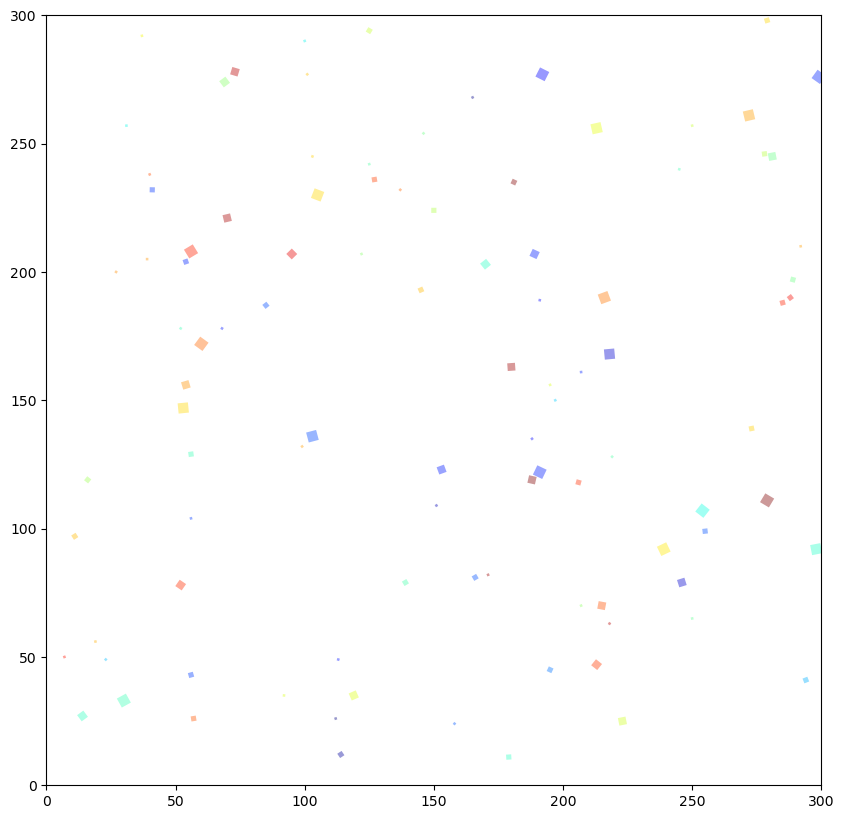

In [210]:
from src.utils.data import loadData

# load data
sq, qp = loadData(100)
print(sq[0])
from src import visualization as vis
vis.plot_data(sq,limits=[0,300,0,300])

## Training Teacher

In [211]:
from src.metrics import Linf
from src.ebmUtils import Reg, RegLatent, loss_functional
from src.train import trainTeacher

In [220]:
model = LVGEBM(4,2,400).to(device)
learning_rate = 1e-2
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
epochs = 200
times = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
train_data = torch.from_numpy(sq).float().to(device)
alpha = 5
beta = 10
results = trainTeacher(model
                          , optimizer
                          , epochs
                          , times
                          , device
                          , train_data
                          , alpha
                          , beta
)

Training Teacher Model
Epoch: 20/200..  Training loss: 7911.00342..  Reg Proj: 0.00000..  Reg Latent: 0.98357..  Memory: 7901.16797..  Cost: 7911.00342.. 
Epoch: 40/200..  Training loss: 9543.07129..  Reg Proj: 0.00000..  Reg Latent: 2.05386..  Memory: 9522.53223..  Cost: 9543.07129.. 
Epoch: 60/200..  Training loss: 8962.37402..  Reg Proj: 0.00000..  Reg Latent: 0.51669..  Memory: 8957.20703..  Cost: 8962.37402.. 
Epoch: 80/200..  Training loss: 8153.16553..  Reg Proj: 0.00000..  Reg Latent: 0.86947..  Memory: 8144.47070..  Cost: 8153.16553.. 
Epoch: 100/200..  Training loss: 9174.02734..  Reg Proj: 0.00000..  Reg Latent: 0.01445..  Memory: 9173.88281..  Cost: 9174.02734.. 
Epoch: 120/200..  Training loss: 7838.16992..  Reg Proj: 0.00000..  Reg Latent: 0.25814..  Memory: 7835.58838..  Cost: 7838.16992.. 
Epoch: 140/200..  Training loss: 8047.95166..  Reg Proj: 0.00000..  Reg Latent: 2.13596..  Memory: 8026.59180..  Cost: 8047.95166.. 
Epoch: 160/200..  Training loss: 9756.73047..  Reg

best epoch:  86
best outputs:  tensor([[227.5926, 101.1054],
        [ 83.6273, 107.8242],
        [101.2507, 230.3911],
        [204.6891, 206.2272]], device='cuda:0', grad_fn=<AddBackward0>)
costs:  [20021.1875, 19968.193359375, 27033.89453125, 19769.833984375, 12365.857421875, 19484.119140625, 35063.81640625, 18842.1015625, 13553.9765625, 16776.234375, 8518.4052734375, 15446.3037109375, 15991.5986328125, 12593.0263671875, 11739.490234375, 9410.466796875, 8633.4912109375, 7035.03076171875, 8079.12451171875, 7911.00341796875, 12444.38671875, 7089.44091796875, 6896.73388671875, 7082.81591796875, 5793.2978515625, 7052.09228515625, 7104.7685546875, 8215.869140625, 7633.4775390625, 8920.228515625, 13438.677734375, 10078.228515625, 7412.1494140625, 8929.4990234375, 10237.279296875, 9037.2080078125, 8003.48828125, 9289.62109375, 7379.7978515625, 9543.0712890625, 7775.1513671875, 9210.6875, 7121.23779296875, 9337.208984375, 6284.33056640625, 8995.2294921875, 7989.52783203125, 9252.6162109375

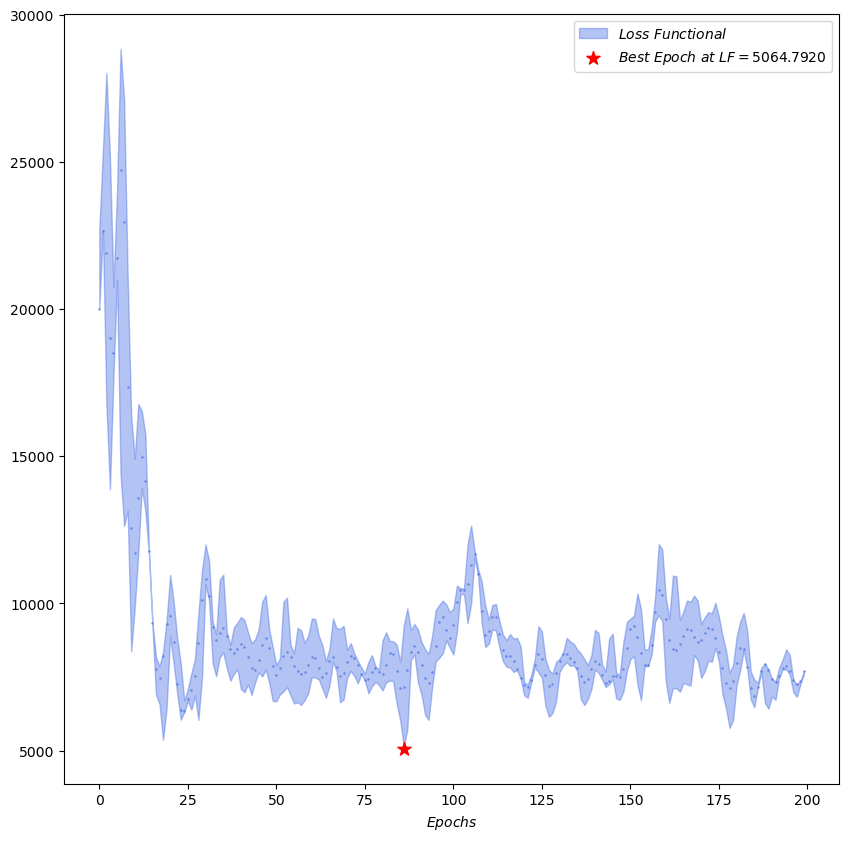

In [221]:
from src.utils.plot_tools import plot_AM_dem, AM_dem
best_outputs = results["best_outputs"]
best_epoch = results["best_epoch"]
costs = results["cost_array"]
best_model = results["best_model"]
print("best epoch: ", best_epoch)
print("best outputs: ", best_outputs)
print("costs: ", costs)
signal = costs
upper_signal, lower_signal, filtered_siganl = AM_dem(signal, fc=0.4*len(signal),fs=2*len(signal))
plot_AM_dem(upper_signal, lower_signal, filtered_siganl, signal, best_epoch)

In [238]:
def save_Teacher_config(results):
    # save results to npy
    res = results.copy()
    np.save("models/squares/100/teacher_config.npy", res)
    print("saved teacher config to results/teacher_config.npy")
save_Teacher_config(results)

    

saved teacher config to results/teacher_config.npy


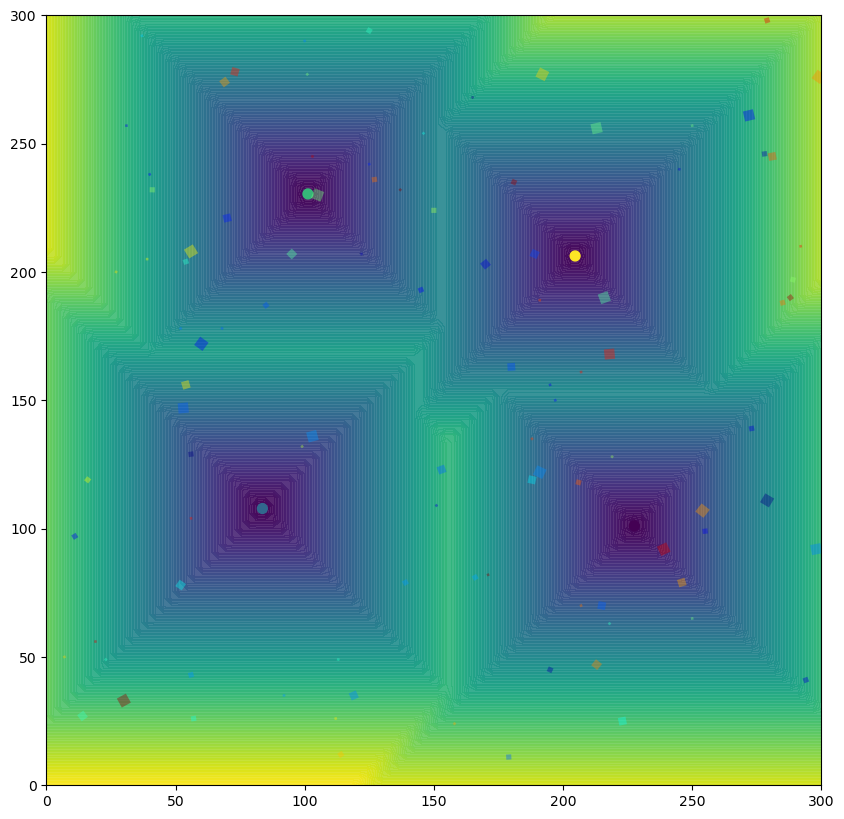

In [222]:
from src.utils import plot_tools as pt
manifold = pt.createManifold(model, best_outputs.cpu())
manifold1 = manifold
pt.plotManifold(sq, manifold, best_outputs.cpu(),[0,300],[0,300])

## UN

Predicting...


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\2969457466.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  E = Linf_array(torch.tensor(outputs), torch.tensor(n_points))


Processing...
flag is 5843
m is 4158
i is 10000
points sampled:  4158


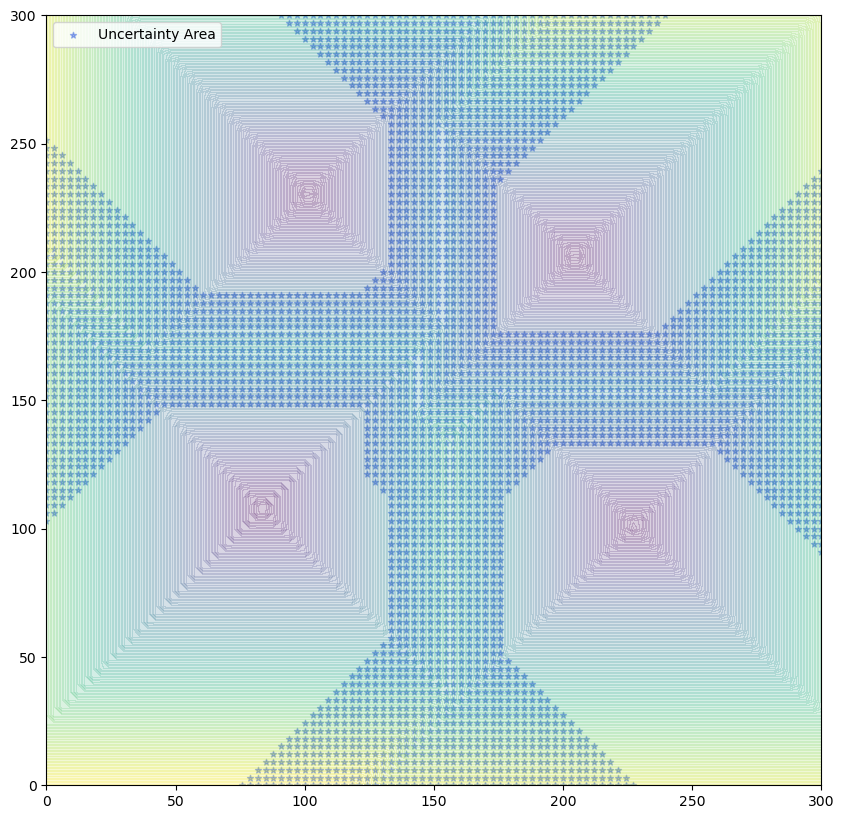

In [224]:
# will sample points on the voronoi edges
# we will label them and fine tune a student network
# the sampler will be a module or a function?
def getUncertaintyArea(outputs, N, M, epsilon, x_area, y_area, model):
    """
        Sample N points in the area defined by x_area and y_area
        
        Parameters:
            outputs: the outputs of the teacher network
            N: number of points to sample
            M: number of points to return
            epsilon: the epsilon ball
            x_area: the x area to sample from
            y_area: the y area to sample from
            model: the teacher network
            
        Returns:
            m_points: the M points that are in the uncertainty area

        #TODO: Create more clever UN sampling
    """
    # first lets sample N points in the spaces defined by x_area and y_area
    n_points = torch.zeros(N**2, 2)
    x_p = np.linspace(x_area[0], x_area[1], N)
    y_p = np.linspace(y_area[0], y_area[1], N)
    for i in range(N**2):
        n_points[i] = torch.tensor([x_p[i%N], y_p[i//N]])
    # now lets get the uncertainty area for each point
    E = Linf_array(torch.tensor(outputs), torch.tensor(n_points))
    # get the min distance
    m_points = []
    m = 0
    i = 0
    flag = 1
    tmp = False
    print('Processing...')
    flag_temp = False
    while m<=M and i < N**2:
        E1 = E[i]
        F1 = E1.min()
        # diff should be E1 - F1 for all points (E1 is a vector ) and F1 is a scalar
        diff = torch.abs(E1 - F1) # diff is a vector
        eps = epsilon * 300 # 300 is the max L_inf dist = a length measure of the space
        cnt = 0 # count the number of centroids that are close to the current point
        for j in range(E1.shape[0]): 
            if diff[j] <= eps and F1 != E1[j]:
                cnt += 1
        if cnt == 1:
            #eps = eps * (1*F1/300 + 200/300) # new eps
            eps = eps * ((1/(F1*0.0001)) )
            # only 2 centroids are close => 1/F1
            tmp = False
            for j in range(E1.shape[0]):
                if diff[j] <= eps and F1 != E1[j]:
                    tmp = True
                    m_points.append(n_points[i])
                    m += 1
                    i += 1
                    break
            if tmp == False:
                    flag_temp = True 
                    
        elif cnt > 1:
            #eps = eps * 1/(0.01*F1) # new eps
            #eps = eps * (F1/300) * cnt
            eps = eps * 2
            # eps = eps * 2
            tmp = False
            for j in range(E1.shape[0]):
                if diff[j] <= eps and F1 != E1[j]:
                    m_points.append(n_points[i])
                    tmp = True
                    m += 1
                    i += 1
                    break
            if tmp != True:
                    flag_temp = True
        else:
            flag += 1
            i += 1
            continue
        if flag_temp == True:
            flag_temp = False
            i += 1
            flag +=1
 
    print(f'flag is {flag}')
    print(f'm is {m}')
    print(f'i is {i}')
    return m_points 

sensitivity = 0.15
N = 100
M = 10000-1
print('Predicting...')
n_p= getUncertaintyArea(best_outputs.cpu().detach().numpy(),N,M, sensitivity, [0,300], [0,300], model)
print('points sampled: ', n_p.__len__())
# plot n_p
n_p = np.array(n_p)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(n_p[:,0], n_p[:,1], s=20, c='royalblue', alpha=0.5, marker='*', label='Uncertainty Area')
# level = levels
ax.contourf(manifold1[:,:,0], manifold1[:,:,1], manifold1[:,:,-2],levels=200,cmap='viridis', alpha=0.2)
plt.legend()

### Labeling

In [225]:
qp = n_p
qp = np.random.permutation(qp)
qp = torch.tensor(qp)
def getE(model, best_outputs, qp):
    """
        Get the Linf distance between the outputs and the qp points
        
        Parameters:
            model: the teacher network
            best_outputs: the outputs of the teacher network
            qp: the points to compare the outputs to
            
        Returns:
            F: the Linf distance between the outputs and the qp points
            z: the index of the qp point that is closest to the output
            F_sq: the Linf distance between the outputs and the sq points
            z_sq: the index of the sq point that is closest to the output
    """
    # get qp
    qp = torch.tensor(qp)
    # get outputs
    outputs = best_outputs
    outputs = torch.tensor(outputs)
    # make Linf between outputs points and qp (between them all)
    E = torch.zeros(outputs.shape[0], qp.shape[0])
    for i in range(outputs.shape[0]):
        for j in range(qp.shape[0]):
            E[i,j] = torch.max(torch.abs(outputs[i] - qp[j]))
    F, z = E.min(0)
    # now do the same for sq
    outputs = outputs.detach().numpy()
    sq_ ,_ = loadData(100)
    E_sq = loss_functional(outputs, sq_, model)
    F_sq, z_sq = E_sq.min(1)
    
    return F, z, F_sq, z_sq

def NearestNeighbour(qp, sq):
    """
        Find the nearest neighbour of qp in sq
        
        Parameters:
            qp: the query point
            sq: the points to compare the query point to
            
        Returns:
            d_nn: the Linf distance between the query point and its nearest neighbour
            z_nn: the index of the nearest neighbour
    """
    d_nn = np.inf
    z_nn = 0
    for i, square in enumerate(sq):
        d_nn_sq,_,_ = Linf(square, qp)
        if d_nn_sq <= d_nn:
            d_nn = d_nn_sq
            z_nn = i
    return d_nn, z_nn

def Accuracy(F, z, F_sq, z_sq, qp, sq):
    """
        Get the accuracy of the model
        
        Parameters:
            F: the Linf distance between the outputs and the qp points
            z: the index of the qp point that is closest to the output
            F_sq: the Linf distance between the outputs and the sq points
            z_sq: the index of the sq point that is closest to the output
            qp: the points to compare the outputs to
            sq: the points to compare the outputs to
            
        Returns:
            acc: the accuracy of the model
    """
    acc = 0
    for i in range(qp.shape[0]):
        # find nn of qp[i]
        d_nn, z_nn = NearestNeighbour(qp[i], sq)
        #print("d_nn: ", d_nn)
        #print("z_nn: ", z_nn)
        #print("z[i]: ", z[i])
        #print("z_sq[z_nn]: ", z_sq[z_nn])
        if z_sq[z_nn] == z[i]:
            acc += 1
    return acc/qp.shape[0]

F, z, F_sq, z_sq = getE(best_model,best_outputs.cpu(), qp)

Loading data...
Data loaded.


C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\1339037055.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\1339037055.py:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = torch.tensor(outputs)


In [226]:
squares, _ = loadData(100) # load the squares 
pseudo_clusters = [] # initialize the pseudo clusters
n_centroids = 4 # number of centroids #TODO: make it a parameter from theinitializer
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i]) 

Loading data...
Data loaded.


In [227]:
# Create Labels
n = 0
outputs = torch.zeros(qp.shape[0], n_centroids)
F_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
z_ps = torch.zeros(outputs.shape[0], outputs.shape[1])
for i in range(outputs.shape[0]):
    for j in range(outputs.shape[1]):
        qpoint = qp[i].cpu().detach().numpy()
        F_ps[i,j], z_ps[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j]))
    if n%1000 == 0:
        print(n)
    n += 1

0
1000
2000
3000
4000


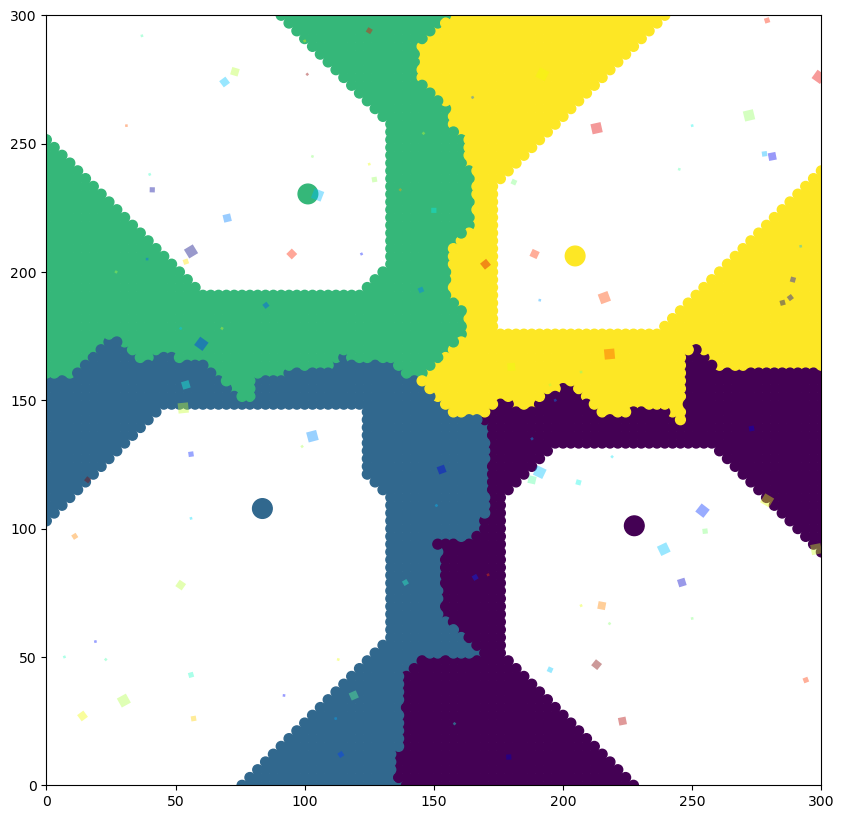

In [228]:
# Plot labels
#plot qp
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
#labels are z
labels =  z
plt_qp = qp.cpu().detach().numpy()
new_labels = F_ps.min(1)[1].cpu().detach().numpy()
ax.scatter(plt_qp[:,0], plt_qp[:,1], c=new_labels, s=50)
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)
z_labels = z
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])
#plot_data(fig,ax,sq, size=10, limits=[0,300,0,300])
# plot p1 = 170,160



## Training Student

In [229]:
from src.models import Voronoi
vor = Voronoi(4, 2, 2).to(device) # initialize the voronoi network
loss = nn.L1Loss() # initialize the loss function
qp = torch.tensor(qp) # send qp to device
optimizer = torch.optim.Adam(vor.parameters(), lr=1e-3) # initialize the optimizer
epochs = 30000 # number of epochs
squares, _ = loadData(100) # load the squares
"""
pseudo_clusters = [] # initialize the pseudo clusters
for i in range(n_centroids):
    # append squares that their z_sq is i
    pseudo_clusters.append(squares[z_sq==i])
"""
F_l = []
z_l = []
cost_l = []
cost_ll = []
qp = torch.tensor(qp).to(device)
outputs = torch.zeros(qp.shape[0], n_centroids)

ce = nn.CrossEntropyLoss()
acc_l = []
l_ce = []
es = []
best_vor_cost = torch.inf
best_vor_mode = None
for epoch in range(epochs):
    qp = torch.tensor(qp, dtype=torch.float32).to(device)
    # get outputs
    outputs = vor(qp)
    # pass outputs through a hard arg max
    F, z = outputs.min(1)
    F_ps_m, z_ps_m = F_ps.min(1)
    # send to device
    F_ps_m = F_ps_m.to(device)
    z_ps_m = z_ps_m.to(device)
    #make values of z_ps_m to be round to nearest integer
    r_z = torch.round(z_ps_m)
    # get loss
    alpha = 100
    beta = 1000
    z = z.float()
    z_ = outputs
    # make z_ float
    z_ = z_.float()
    z_cost = ce(z_, z_ps_m)
    F_cost = loss(F, F_ps_m)
    # get z_cost where we only penalize the wrong z and not its distance
    #z_cost = penalty(z, r_z)
    #F_l.append(F_cost.item())
    z_l.append(z_cost)
    #cost = alpha*F_cost + beta*z_cost
    cost = 100*z_cost 
    cost_l.append(cost.item())
    # backward
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if cost < best_vor_cost:
        best_vor_cost = cost
        best_vor_model = vor
    if epoch%2000==0:
        # lets check acc
        acc = 0
        for i in range(qp.shape[0]):
            F_e, z_e = outputs[i].max(0)
            if z_e == z_ps_m[i]:
                acc += 1
        acc_l.append(acc/qp.shape[0])
        es.append(epoch)
        cost_ll.append(cost.item())

        if epoch%200==0:
            print("Acc: ", acc/qp.shape[0])
            print("Epoch: ", epoch, "Cost: ", cost.item())

C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\3927861050.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp) # send qp to device
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\3927861050.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp).to(device)
C:\Users\panagiotis.rigas\AppData\Local\Temp\ipykernel_10732\3927861050.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  qp = torch.tensor(qp, dtype=torch.float32).to(device)


Loading data...
Data loaded.
Acc:  0.22318422318422318
Epoch:  0 Cost:  2320.69140625
Acc:  0.9422799422799423
Epoch:  2000 Cost:  25.369029998779297
Acc:  0.9456469456469456
Epoch:  4000 Cost:  16.157894134521484
Acc:  0.9634439634439634
Epoch:  6000 Cost:  12.866488456726074
Acc:  0.9704184704184704
Epoch:  8000 Cost:  11.237709999084473
Acc:  0.936988936988937
Epoch:  10000 Cost:  13.425029754638672
Acc:  0.9682539682539683
Epoch:  12000 Cost:  9.957328796386719
Acc:  0.9773929773929774
Epoch:  14000 Cost:  9.261085510253906
Acc:  0.9737854737854738
Epoch:  16000 Cost:  9.199464797973633
Acc:  0.9442039442039442
Epoch:  18000 Cost:  11.913651466369629
Acc:  0.9581529581529582
Epoch:  20000 Cost:  9.81735897064209
Acc:  0.9641654641654641
Epoch:  22000 Cost:  9.348736763000488
Acc:  0.9312169312169312
Epoch:  24000 Cost:  14.385567665100098
Acc:  0.9754689754689755
Epoch:  26000 Cost:  7.8742547035217285
Acc:  0.9788359788359788
Epoch:  28000 Cost:  7.418516159057617


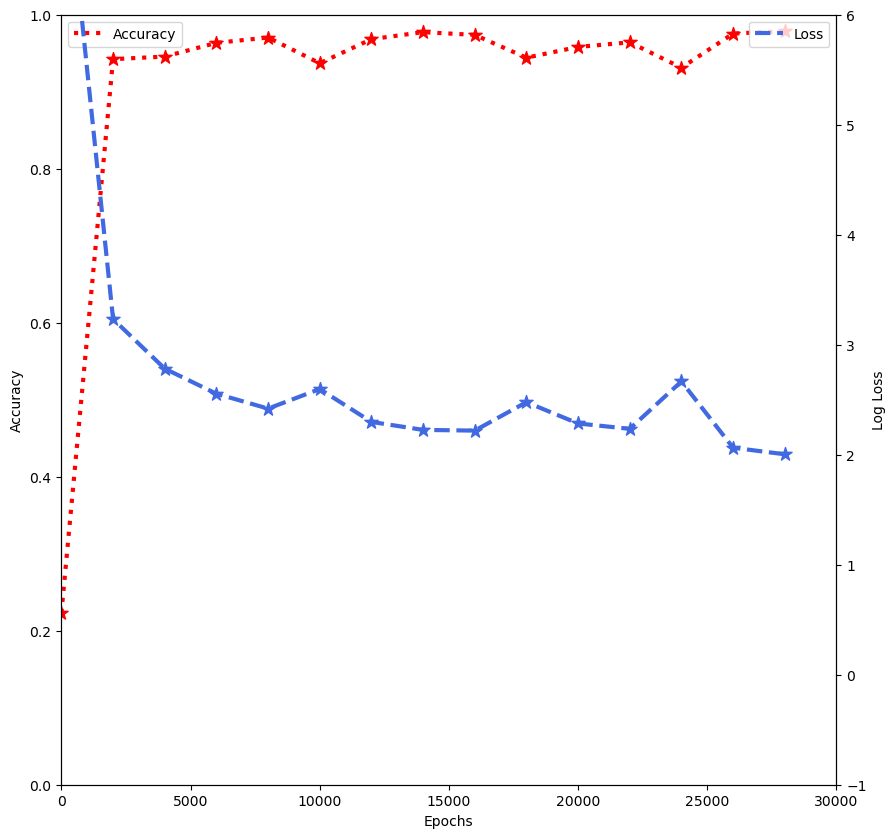

In [230]:
# Plot Accuracy and Loss
cost_ll_log = np.log(cost_ll)
    
fig, ax1 = plt.subplots(figsize=(10,10))
ax1.plot(es,acc_l, c='r', label='Accuracy', linestyle='dotted',linewidth=3)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')
ax1.set_ylim([0, 1])
# create another twin axis
ax2 = ax1.twinx()
ax2.plot(es,cost_ll_log, c='royalblue', label='Loss', linestyle='dashed',linewidth=3)
ax2.set_ylabel('Log Loss')
ax2.legend(loc='upper right')
ax2.set_ylim([-1, 6])
# set x_lim in both
ax1.set_xlim([0, epochs])
ax2.set_xlim([0, epochs])
# add stars to the plot points
ax1.scatter(es,acc_l, c='r', s=100, marker='*')
ax2.scatter(es,cost_ll_log, c='royalblue', s=100, marker='*')

In [ ]:
# save voronoi model
def save_Student_config(model):
    # save model
    torch.save(model.state_dict(), "models/squares/100/student_config.pt")
    print("saved student config to results/student_config.pt")
save_Student_config(best_vor_model)

## Inferencing

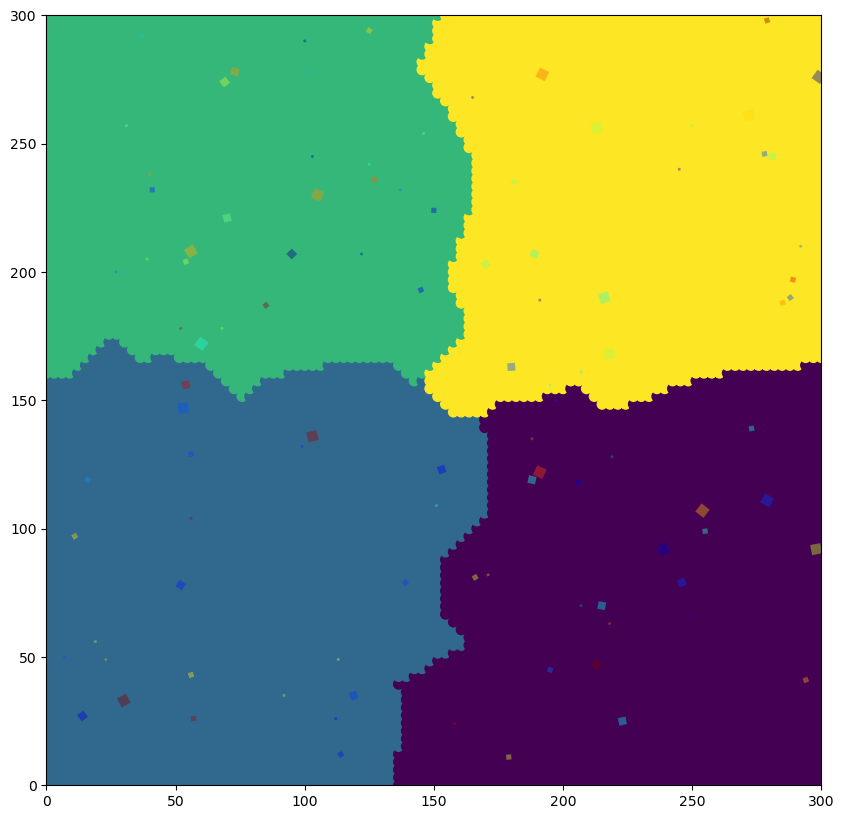

In [231]:
# ok lets infer
infer_points = torch.zeros(10000, 2) # initialize the infer points
x_lim = [0,300] # x limits
y_lim = [0,300] # y limits
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], 100)): # sample 100 points in x_lim
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], 100)): # sample 100 points in y_lim
        infer_points[i*100+j] = torch.Tensor([x, y]) # append the point to infer_points
        
infer_points = infer_points.to(device) # send infer_points to device
classes = best_vor_model(infer_points) # get the classes of infer_points
infer_points = infer_points.cpu().detach().numpy() # send infer_points to cpu
classes = classes.max(1)[-1].cpu().detach().numpy() # send classes to cpu
# plot classes
fig = plt.figure(figsize=(10,10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
#manifold_plot = manifold_plot.cpu().detach().numpy()
ax.scatter(infer_points[:,0], infer_points[:,1], c=classes, s=50) # plot infer_points
#ax.contourf(manifold1[:,:,0], manifold1[:,:,1], classes, levels=level, cmap='viridis', alpha=0.9)
# plot scatter of output = model(model.z)
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300]) # plot sq

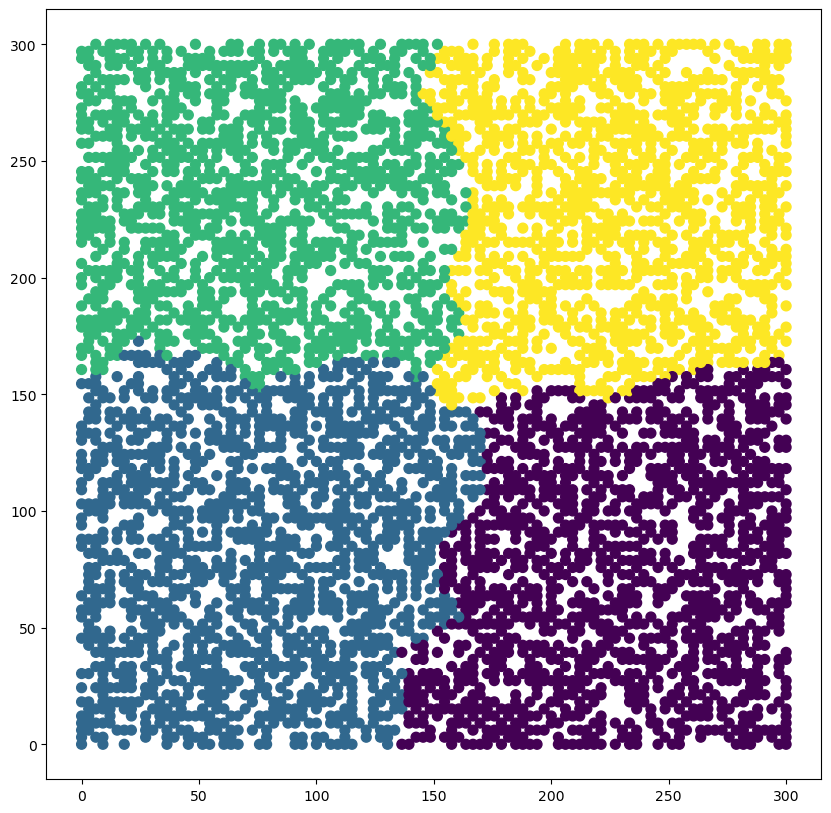

In [232]:
# take 10000 points randomly in [0,300]x[0,300]
random_p = torch.zeros(10000, 2)
x_lim = [0,300]
y_lim = [0,300]
for i, x in enumerate(np.linspace(x_lim[0],x_lim[1], 100)):
    for j, y in enumerate(np.linspace(y_lim[0],y_lim[1], 100)):
        random_p[i*100+j] = torch.Tensor([x, y])

infer_points = random_p.to(device)
# take 5000 randomly of those
num = 5000
infer_points = random_p[torch.randperm(random_p.shape[0])][:5000]
# =
infer_points = infer_points.to(device)
classes = best_vor_model(infer_points)
z = classes.max(1)[-1].cpu().detach().numpy()
infer_points = infer_points.cpu().detach().numpy()
# plot infer_points
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.scatter(infer_points[:,0], infer_points[:,1], c=z, s=50)

In [233]:
# randomly infered points
#infer_points = torch.randn(10000, 2)
# they must be in [0,300]x[0,300]
#infer_points = infer_points*150 + 150
n = 0 # counter
outputs = torch.zeros(infer_points.shape[0], n_centroids) # initialize outputs
F_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1]) # initialize F_ps
z_ps_infer = torch.zeros(outputs.shape[0], outputs.shape[1]) # initialize z_ps
for i in range(outputs.shape[0]): # for each infer point
    for j in range(outputs.shape[1]): # for each pseudo cluster
        qpoint = infer_points[i] # get the infer point
        F_ps_infer[i,j], z_ps_infer[i,j] = torch.tensor(NearestNeighbour(qpoint, pseudo_clusters[j])) # get the Linf distance between the infer point and the pseudo cluster
    if n%1000 == 0: # print every 1000 points
        print(n) # print n
    n += 1 # increment n
z_i = F_ps_infer.min(1)[1].cpu().detach().numpy() # get the z_i

0
1000
2000
3000
4000


In [234]:
# Get Accuracy
# get all the number of times z == z_i
times = [z==z_i]
print(np.sum(times)/z.shape[0])
print("Number of false predictions: ", z.shape[0] - np.sum(times))

0.991
Number of false predictions:  45


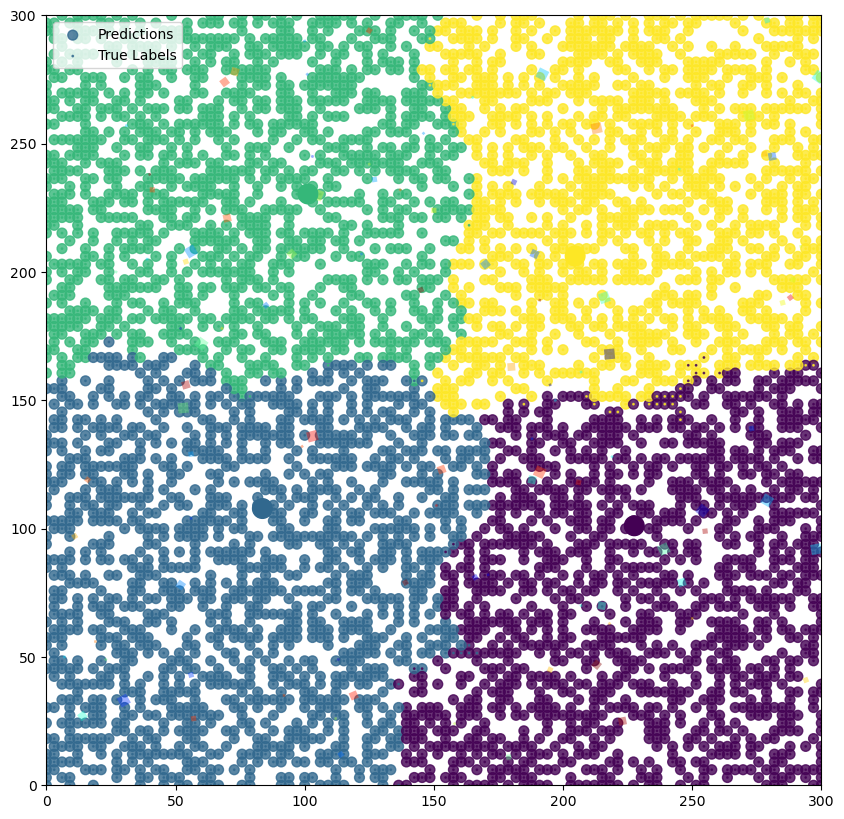

In [235]:
# plot points
fig = plt.figure(figsize=(10,10)) # initialize the figure
ax = fig.add_subplot(111) # add subplot
infer_points_plt = infer_points # infer_points
#z = z
classes_ = z # z
ax.scatter(infer_points_plt[:,0], infer_points_plt[:,1],c=z, s=50, label='Predictions', alpha=0.8) # plot infer_points
# plot z_i labels
# color
classes_ = z_i # z_i
ax.scatter(infer_points_plt[:,0], infer_points_plt[:,1], c=classes_, s=1, label='True Labels', alpha=0.8) # plot infer_points
ax.set_xlim([0,300])
ax.set_ylim([0,300])
# plot legend
plt.legend(scatterpoints=1, loc='upper left', fontsize=10)
# also vis data
pt.plot_data_on_manifold(fig, ax, sq,size=10, limits=[0,300,0,300])
# plot best_outputs
plt_bo = best_outputs.cpu().detach().numpy()
plt_bo = plt_bo
c = np.linspace(0, best_outputs.shape[0], best_outputs.shape[0])
ax.scatter(plt_bo[:,0], plt_bo[:,1], c=c, s=200)

